# Using Long short term memory networks for streamflow prediction

Refrence links:


1. [Single basin LSTM](https://github.com/kratzert/pangeo_lstm_example)
2. [Neural Hydrology](https://neuralhydrology.github.io)
3.  [EA-LSTM](https://github.com/kratzert/ealstm_regional_modeling)
4. [Prediction in ungauged basins](https://github.com/kratzert/lstm_for_pub)

Please make your own copy of this notebook and work on your copy. Each section can then be merged after discussion in this final notebook.

# **Import Libraries**

In [ ]:
_from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import glob
import shutil
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import random
import warnings
import joblib
from typing import TYPE_CHECKING, Any, Union
import proplot as pplt
import geopandas as gpd
import path

In [ ]:


os.chdir('/content/drive/MyDrive/Machine_Learning_Course/')


# 1) Data download, loading and exploration
Start by downloading CAMELS data, loading into notebook and exploring attributes in this format:

| Basin_ID | Date | Precip | Climate | Vegetation | Topography | Soil | Geology | Streamflow |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|





In [ ]:
def import_attributes(folder, attr_subset=None, return_list=False):
    attr_files = glob.glob(os.path.join(folder, 'camels_*.txt'))
    print(f"Found files: {attr_files}")

    if not attr_files:
        print("No files found. Check the folder path or file pattern.")
        return [] if return_list else pd.DataFrame()

    if attr_subset is not None:
        new_list = []
        for file in attr_files:
            attr = os.path.basename(file).split('_')[1]
            if attr in attr_subset:
                new_list.append(file)
        if not new_list:
            raise ValueError('attrSubset contained no valid attribute names')
        attr_files = new_list

    basin_attr = None
    basin_list = []
    for afile in attr_files:
        rfile = pd.read_csv(afile, sep=';')
        if 'gauge_id' not in rfile.columns:
            print(f"'gauge_id' column not found in {afile}.")
        else:
            rfile.set_index('gauge_id', inplace=True)


        if basin_attr is None:
            basin_attr = rfile
        else:
            try:
                basin_attr = basin_attr.merge(rfile, left_index=True, right_index=True)
            except Exception as e:
                print(f"Unable to merge {afile} based on 'gauge_id'. Error: {e}")

        if return_list:
            basin_list.append(rfile)

    if return_list:
        return basin_list
    else:
        return basin_attr

camels_dir = '/content/drive/MyDrive/Machine_Learning_Course/'
CAMELS_LongTerm_All = import_attributes(camels_dir)
CAMELS_LongTerm_All = pd.DataFrame(CAMELS_LongTerm_All)
CAMELS_LongTerm_All = CAMELS_LongTerm_All.reset_index()
CAMELS_LongTerm_All#.head(4)

Found files: ['/content/drive/MyDrive/Machine_Learning_Course/camels_clim.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_name.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_geol.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_vege.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_hydro.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_soil.txt', '/content/drive/MyDrive/Machine_Learning_Course/camels_topo.txt']


,gauge_id,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,...,clay_frac,water_frac,organic_frac,other_frac,gauge_lat,gauge_lon,elev_mean,slope_mean,area_gages2,area_geospa_fabric
0,1013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,...,16.275732,5.376698,0.408717,0.000000,47.23739,-68.58264,250.31,21.64152,2252.70,2303.95
1,1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,...,12.037646,1.226913,0.000000,0.358472,44.60797,-67.93524,92.68,17.79072,573.60,620.38
2,1030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,...,14.776824,1.634345,1.330278,0.022016,45.50097,-68.30596,143.80,12.79195,3676.17,3676.09
3,1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,...,12.654125,0.674594,0.000000,0.000000,45.17501,-69.31470,247.80,29.56035,769.05,766.53
4,1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,...,10.303622,0.000000,0.000000,0.147867,44.86920,-69.95510,310.38,49.92122,909.10,904.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,4.977781,3.122204,-0.995847,0.061255,0.627228,15.10,1.776471,djf,222.65,...,23.213862,0.000000,0.000000,0.000000,42.80400,-123.61091,709.83,110.42527,224.92,226.31
667,14316700,4.543400,2.277630,-0.821172,0.176337,0.501305,14.75,1.446078,djf,214.85,...,24.363634,0.000000,0.000000,0.000000,43.34984,-122.72894,952.26,119.08920,587.90,588.01
668,14325000,6.297437,2.434652,-0.952055,0.030203,0.386610,14.60,1.467337,djf,219.05,...,20.068726,0.000000,0.000000,0.000000,42.89150,-124.07065,656.53,124.96889,443.07,444.92
669,14362250,2.781676,3.325188,-0.985486,0.141500,1.195390,20.45,1.786026,djf,260.35,...,22.404372,0.000000,0.000000,0.000000,42.15401,-123.07532,875.67,109.93127,41.42,43.88


In [ ]:
CAMELS_LongTerm_All.columns

Index(['gauge_id', 'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
       'aridity', 'high_prec_freq', 'high_prec_dur', 'high_prec_timing',
       'low_prec_freq', 'low_prec_dur', 'low_prec_timing', 'huc_02',
       'gauge_name', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
       'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'frac_forest', 'lai_max', 'lai_diff', 'gvf_max',
       'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50',
       'root_depth_99', 'q_mean', 'runoff_ratio', 'slope_fdc',
       'baseflow_index', 'stream_elas', 'q5', 'q95', 'high_q_freq',
       'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'hfd_mean',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity',
       'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac',
       'clay_frac', 'water_frac', 'organic_frac', 'other_frac', 'gauge_lat',
       'gauge_lon', 'elev_mean', 'slope_mean', 'area_g

# Plot longTerm CAMELS values

In [ ]:
path = '/content/drive/MyDrive/Machine_Learning_Course'

<ipython-input-36-23d51d6e0671>:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
<ipython-input-36-23d51d6e0671>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  attrs['geometry_points'] = attrs['geometry'].centroid
<ipython-input-36-23d51d6e0671>:35: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


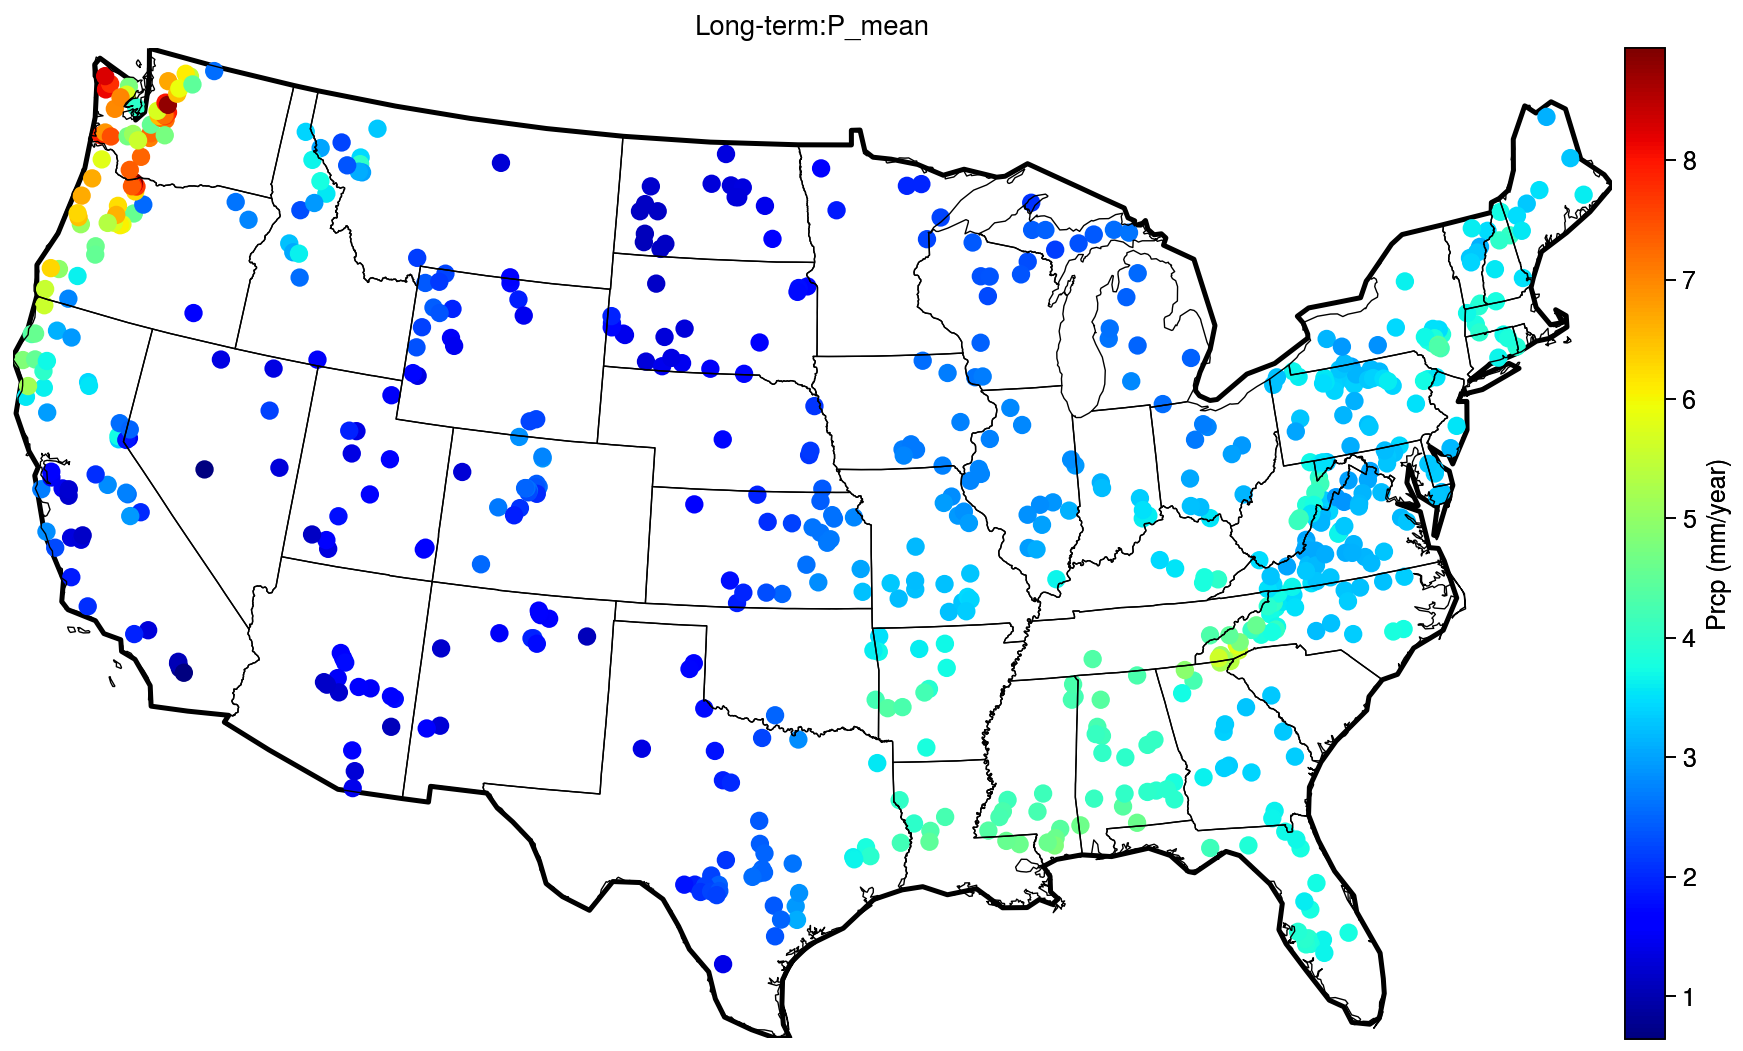

In [ ]:
# State boundary
states_all = gpd.read_file('/content/drive/MyDrive/Machine_Learning_Course/States_shapefile.shp').to_crs(5070)
states = states_all[~states_all['State_Name'].isin(['ALASKA', 'HAWAII'])]

# D:\Data\CAMELS

# CONUS
attrs = gpd.read_feather('/content/drive/MyDrive/Machine_Learning_Course/camels_attributes_v2.0.feather')
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geom = world[world.iso_a3 == "USA"].geometry.iloc[0].geoms[0]
conus = gpd.GeoSeries(conus_geom, crs=world.crs).to_crs(5070)
attrs = attrs.reset_index(drop=False)

# Merge Attributes basd on the gauge_id
attrs['gauge_id'] = attrs['gauge_id'].astype(str).apply(lambda x: '0' + x if not x.startswith('0') else x)

# Create a new column to store the point geometries
attrs['geometry_points'] = attrs['geometry'].centroid
# Convert the 'geometry_points' column to the geometry column
attrs = attrs.set_geometry('geometry_points')
# Drop the temporary 'geometry_points' column
attrs = attrs.drop(columns=['geometry'])


# Plotting
conus = gpd.GeoSeries(conus_geom, crs=world.crs).to_crs(5070)
fig, ax = pplt.subplots(refwidth=8, facecolor="w")
ax.format(grid=False, title="Long-term:P_mean")
conus.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1.8)
attrs.to_crs(5070).plot(ax=ax, column="p_mean", legend=True, cmap="jet", legend_kwds={'label': "Prcp (mm/year)"})

# Plot the state boundaries
states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_axis_off()
fig.tight_layout()
ax.margins(0)

# The HUC2 level (Main 18 Basins in CONUS)


In [ ]:
!mkdir -p '/content/drive/MyDrive/Machine_Learning_Course/daymet'
!unrar x '/content/drive/MyDrive/Machine_Learning_Course/daymet.rar' '/content/drive/MyDrive/Machine_Learning_Course/daymet/'

In [ ]:
# There are 677 text files (.txt) in all 18 basins
directory_path = r'/content/drive/MyDrive/Machine_Learning_Course/daymet/daymet'

total_files = sum(len([file for file in os.listdir(os.path.join(directory_path, folder)) if os.path.isfile(os.path.join(directory_path, folder, file))]) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder)))
print(f'Total Number of Basins: {total_files}')

for folder in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder)
    if os.path.isdir(folder_path):
        num_files = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

        print(f"'{folder}' : {num_files} files.")

Total Number of Basins: 677
'01' : 28 files.
'02' : 75 files.
'03' : 93 files.
'04' : 31 files.
'05' : 45 files.
'06' : 18 files.
'07' : 33 files.
'08' : 12 files.
'09' : 9 files.
'10' : 72 files.
'11' : 31 files.
'12' : 37 files.
'13' : 7 files.
'14' : 17 files.
'15' : 20 files.
'16' : 18 files.
'17' : 91 files.
'18' : 40 files.


# a) Daymet Forcing -- single Basin (01 under the daymet folder)

In [ ]:
def read_basin_forcing(file_path):
    try:
        return pd.read_csv(file_path, sep='\s+', skiprows=3)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def import_daymet_forcings_for_first_folder(base_folder):
    daymet_first_folder = os.path.join(base_folder, 'daymet', '01')     # For one basin
    daymet_df = pd.DataFrame()

    if not os.path.exists(daymet_first_folder):
        print(f"Folder does not exist: {daymet_first_folder}")
        return daymet_df

    for file in os.listdir(daymet_first_folder):
        if file.endswith('.txt'):
            full_path = os.path.join(daymet_first_folder, file)
            df = read_basin_forcing(full_path)
            if df is not None:
                # Prepend the gauge_id column
                df.insert(0, 'gauge_id', os.path.basename(file).split('_')[0])
                daymet_df = pd.concat([daymet_df, df], ignore_index=True)

    return daymet_df

# Usage
base_folder = '/content/drive/MyDrive/Machine_Learning_Course/daymet/'
daymet_01_basin = import_daymet_forcings_for_first_folder(base_folder)

# Drop some columns
columns_to_drop = ['Hr', 'dayl(s)', 'vp(Pa)', 'srad(W/m2)', 'swe(mm)']
daymet_01_basin.drop(columns=columns_to_drop, inplace=True)

daymet_01_basin.dropna(inplace=True)
# combine 'Year', 'Mnth', and 'Day'
daymet_01_basin['Date'] = pd.to_datetime(
    daymet_01_basin['Year'].astype(int).astype(str) + '-' +
    daymet_01_basin['Mnth'].astype(int).apply(lambda x: f'{x:02d}') + '-' +
    daymet_01_basin['Day'].astype(int).apply(lambda x: f'{x:02d}')
)

# Drop 'Year', 'Mnth', and 'Day'
daymet_01_basin.drop(['Year', 'Mnth', 'Day'], axis=1, inplace=True)

# Reindex the DataFrame to place 'Date' at the front
daymet_01_basin = daymet_01_basin[['Date', 'gauge_id', 'prcp(mm/day)', 'tmax(C)', 'tmin(C)']]
daymet_01_basin

,Date,gauge_id,prcp(mm/day),tmax(C),tmin(C)
0,1980-01-01,01013500,0.00,-6.54,-16.30
1,1980-01-02,01013500,0.00,-6.18,-15.22
2,1980-01-03,01013500,0.00,-9.89,-18.86
3,1980-01-04,01013500,0.00,-10.98,-19.76
4,1980-01-05,01013500,0.00,-11.29,-22.21
...,...,...,...,...,...
357947,2014-12-27,04296000,0.00,3.87,-0.95
357948,2014-12-28,04296000,2.77,5.40,-1.07
357949,2014-12-29,04296000,1.61,2.43,-7.32
357950,2014-12-30,04296000,0.00,-6.50,-16.07


## 2) Running LSTM on single basin
Replicate the single basin LSTM model, see ref link 1.

## 3) Create KGE loss function in Pytorch

---------------------------------------------------------   Until Apr 16 ---------------------------------------------------------

## 4) Multi-basin training

## 5) Validation on pseudo-ungauged basins